Data source import complete.
Extracting features...
Maximum caption length: 30
Epoch 1/30

Epoch 1: val_loss improved from inf to 5.53894, saving model to best_model_8090.keras
4129/4129 - 178s - 43ms/step - loss: 9.1291 - val_loss: 5.5389 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 5.53894 to 5.09888, saving model to best_model_8090.keras
4129/4129 - 170s - 41ms/step - loss: 5.3246 - val_loss: 5.0989 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 5.09888 to 4.90073, saving model to best_model_8090.keras
4129/4129 - 168s - 41ms/step - loss: 4.9775 - val_loss: 4.9007 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 4.90073 to 4.72027, saving model to best_model_8090.keras
4129/4129 - 169s - 41ms/step - loss: 4.6829 - val_loss: 4.7203 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_loss improved from 4.72027 to 4.64930, saving model to best_model_8090.keras
4129/4129 - 168s - 41ms/step - loss: 4.4482 - val_l

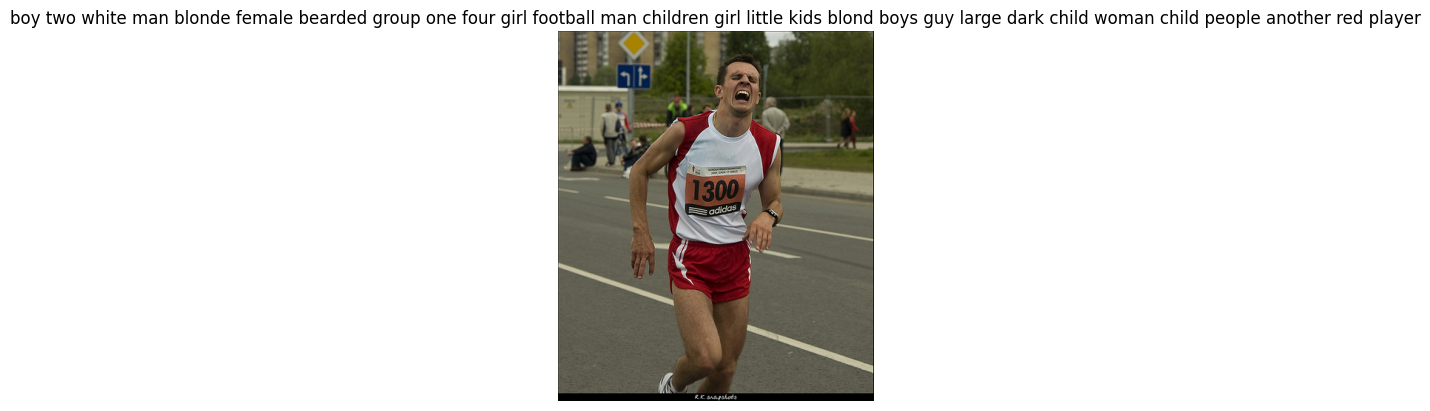

Image: 3547704737_57d42d5d9d.jpg, Caption: boy two white man blonde female bearded group one four girl football man children girl little kids blond boys guy large dark child woman child people another red player


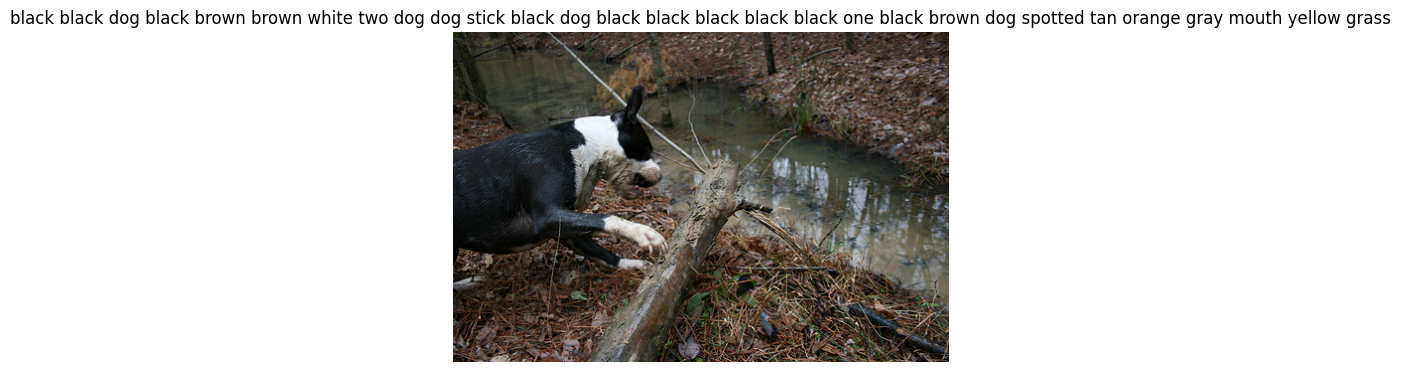

Image: 3393152604_27bd1037f2.jpg, Caption: black black dog black brown brown white two dog dog stick black dog black black black black black one black brown dog spotted tan orange gray mouth yellow grass


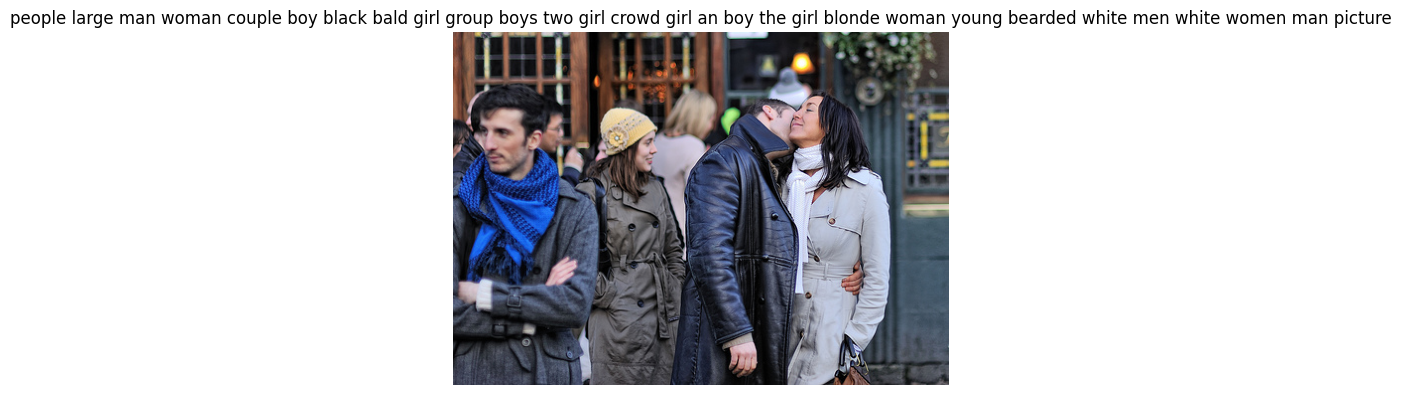

Image: 3549673305_4dfd44e04a.jpg, Caption: people large man woman couple boy black bald girl group boys two girl crowd girl an boy the girl blonde woman young bearded white men white women man picture


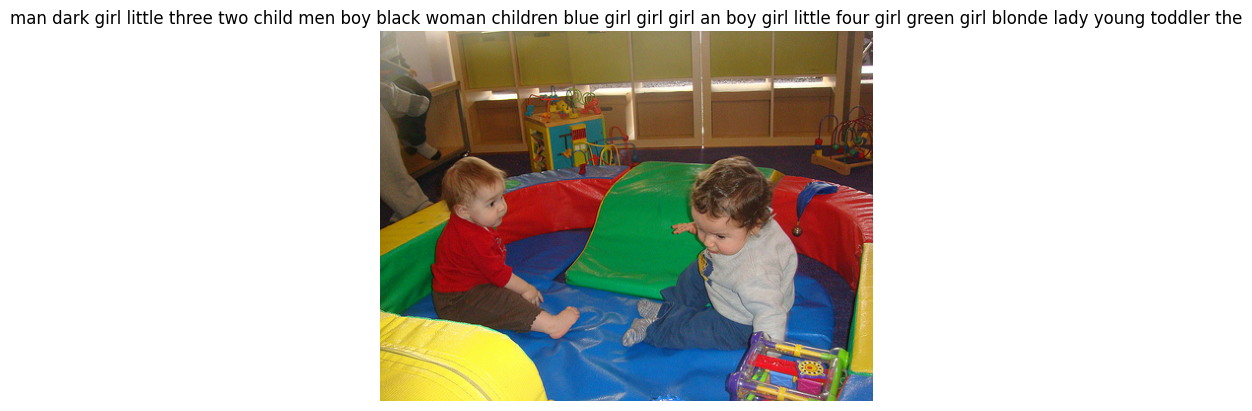

Image: 3181328245_7c04ce1691.jpg, Caption: man dark girl little three two child men boy black woman children blue girl girl girl an boy girl little four girl green girl blonde lady young toddler the


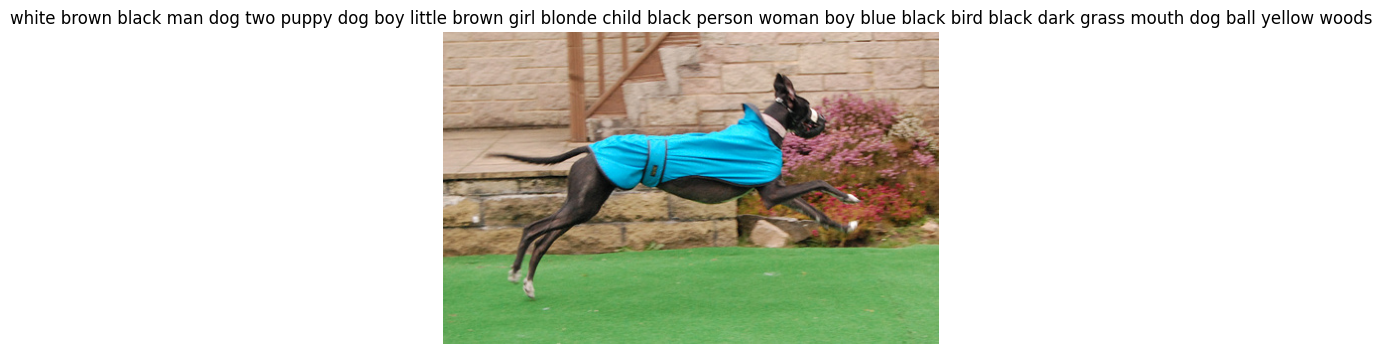

Image: 2393410666_b8c20fff61.jpg, Caption: white brown black man dog two puppy dog boy little brown girl blonde child black person woman boy blue black bird black dark grass mouth dog ball yellow woods


In [2]:
import kagglehub
import os
import pandas as pd
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pickle
import string
import matplotlib.pyplot as plt

dataset_path = kagglehub.dataset_download('adityajn105/flickr8k')
print('Data source import complete.')

image_dir = os.path.join(dataset_path, 'Images')
caption_file = os.path.join(dataset_path, 'captions.txt')

if not os.path.exists(image_dir):
    raise FileNotFoundError(f"مجلد الصور {image_dir} غير موجود.")
if not os.path.exists(caption_file):
    raise FileNotFoundError(f"ملف الـ captions {caption_file} غير موجود.")

def load_reduced_captions(image_dir, caption_file, max_images=8090):
    df = pd.read_csv(caption_file)
    df['image'] = df['image'].apply(lambda x: os.path.join(image_dir, x))
    selected = df.groupby('image').first().reset_index()
    selected = selected[:max_images]
    selected['caption'] = selected['caption'].apply(lambda x: 'startseq ' + x + ' endseq')
    captions = dict(zip(selected['image'], selected['caption']))
    image_paths = list(captions.keys())
    train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
    train_captions = {k: captions[k] for k in train_paths}
    val_captions = {k: captions[k] for k in val_paths}
    return train_captions, val_captions

def extract_features_subset(image_paths):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )
    features = {}
    for img_path in image_paths:
        try:
            img = load_img(img_path, target_size=(224, 224))
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)
            for batch in datagen.flow(img, batch_size=1):
                feature = model.predict(batch, verbose=0)
                features[os.path.basename(img_path)] = feature.flatten()
                break
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return features

def create_tokenizer(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions.values())
    return tokenizer

def max_caption_length(captions):
    max_len = max(len(c.split()) for c in captions.values())
    print(f"Maximum caption length: {max_len}")
    return max_len

def create_sequences(captions, features, tokenizer, max_length, vocab_size):
    X1, X2, y = [], [], []
    for img, caption in captions.items():
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(features[os.path.basename(img)])
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

def load_descriptions(doc):
    descriptions = {}
    for line in doc.strip().split('\n'):
        tokens = line.split('\t')
        if len(tokens) < 2:
            continue
        image_id, image_desc = tokens[0].split('#')[0], tokens[1]
        if image_id not in descriptions:
            descriptions[image_id] = []
        descriptions[image_id].append('startseq ' + image_desc.strip() + ' endseq')
    return descriptions

def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.lower()
            desc = desc.translate(table)
            words = desc.split()
            cleaned_words = []
            prev_word = None
            for word in words:
                if word != prev_word or (prev_word and word not in ('a', 'the')):  
                    if len(word) > 1 and word.isalpha():  
                        cleaned_words.append(word)
                prev_word = word
            desc_list[i] = ' '.join(cleaned_words)

def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 512)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(512, recurrent_dropout=0.2, kernel_regularizer=l2(0.01))(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001))
    return model

train_captions, val_captions = load_reduced_captions(image_dir, caption_file, max_images=8090)

descriptions = {k: [v] for k, v in {**train_captions, **val_captions}.items()}
clean_descriptions(descriptions)
train_captions = {k: descriptions[k][0] for k in train_captions}
val_captions = {k: descriptions[k][0] for k in val_captions}

all_captions = {**train_captions, **val_captions}
image_paths = list(all_captions.keys())

features_file = 'features_8090.pkl'
if os.path.exists(features_file):
    print(f"Loading existing features from {features_file}...")
    with open(features_file, 'rb') as f:
        features = pickle.load(f)
else:
    print("Extracting features...")
    features = extract_features_subset(image_paths)

tokenizer = create_tokenizer(train_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max_caption_length(train_captions)

X1_train, X2_train, y_train = create_sequences(train_captions, features, tokenizer, max_length, vocab_size)
X1_val, X2_val, y_val = create_sequences(val_captions, features, tokenizer, max_length, vocab_size)

model = define_model(vocab_size, max_length)

checkpoint = ModelCheckpoint('best_model_8090.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

model.fit([X1_train, X2_train], y_train, validation_data=([X1_val, X2_val], y_val), 
          epochs=30, batch_size=16, verbose=2, callbacks=[checkpoint, early_stopping, reduce_lr])

model.save('final_model_8090.keras')

doc = load_doc(caption_file)
descriptions = load_descriptions(doc)
clean_descriptions(descriptions)

keys = list(descriptions.keys())[:8090]
descriptions = {k: descriptions[k] for k in keys}

with open('descriptions_8090.pkl', 'wb') as f:
    pickle.dump(descriptions, f)
with open('features_8090.pkl', 'wb') as f:
    pickle.dump({k: features[k] for k in keys}, f)
with open('tokenizer_8090.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('X1_train_8090.pkl', 'wb') as f:
    pickle.dump(X1_train, f)
with open('X2_train_8090.pkl', 'wb') as f:
    pickle.dump(X2_train, f)
with open('y_train_8090.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('X1_val_8090.pkl', 'wb') as f:
    pickle.dump(X1_val, f)
with open('X2_val_8090.pkl', 'wb') as f:
    pickle.dump(X2_val, f)
with open('y_val_8090.pkl', 'wb') as f:
    pickle.dump(y_val, f)

files_to_check = [
    'descriptions_8090.pkl',
    'features_8090.pkl',
    'tokenizer_8090.pkl',
    'X1_train_8090.pkl',
    'X2_train_8090.pkl',
    'y_train_8090.pkl',
    'X1_val_8090.pkl',
    'X2_val_8090.pkl',
    'y_val_8090.pkl',
    'best_model_8090.keras',
    'final_model_8090.keras'
]

for file in files_to_check:
    if os.path.exists(file):
        print(f"{file} saved ")
    else:
        print(f"{file} missing ")

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def beam_search_predictions(model, feature, tokenizer, max_length, beam_index=15, temperature=1.0, top_k=50):
    try:
        start = [tokenizer.word_index['startseq']]
    except KeyError:
        print("خطأ: الكلمة 'startseq' غير موجودة في التوكنايزر.")
        return ""
    sequences = [[start, 0.0, set()]]  
    used_words = {0: set()}
    while len(sequences[0][0]) < max_length:
        all_candidates = []
        for idx, (seq, score, used) in enumerate(sequences):  # Unpacking مع used_words
            padded_seq = pad_sequences([seq], maxlen=max_length, padding='post')[0]
            padded_seq = np.array([padded_seq], dtype=np.int32)
            if feature.shape != (4096,):
                feature = feature.flatten()
            feature = np.array([feature], dtype=np.float32)
            preds = model.predict([feature, padded_seq], verbose=0)
            preds = np.log(preds + 1e-10) / temperature
            preds = np.exp(preds) / np.sum(np.exp(preds))
            top_words = np.argsort(preds[0])[-top_k:]
            top_probs = preds[0][top_words]
            top_probs = top_probs / np.sum(top_probs)
            for i, word in enumerate(top_words):
                if word in used:  
                    top_probs[i] *= 0.1
            top_probs = top_probs / np.sum(top_probs)
            diversity_penalty = 0.3
            for i, word in enumerate(top_words):
                for other_idx, (other_seq, _, _) in enumerate(sequences):
                    if other_idx != idx and word in other_seq:
                        top_probs[i] -= diversity_penalty * top_probs[i]
            top_probs = top_probs / np.sum(top_probs)
            selected_word = np.random.choice(top_words, p=top_probs)
            new_seq = seq + [selected_word]
            new_used_words = used.copy()
            new_used_words.add(selected_word)
            all_candidates.append([new_seq, score - np.log(preds[0][selected_word]), new_used_words])
        all_candidates = sorted(all_candidates, key=lambda x: x[1])[:beam_index]
        sequences = all_candidates  
        used_words = {i: cand[2] for i, cand in enumerate(all_candidates)}
        if any(seq[-1] == tokenizer.word_index.get('endseq', 0) for seq, _, _ in sequences):
            break
    sequence = sequences[0][0]
    caption = []
    for word_id in sequence:
        word = word_for_id(word_id, tokenizer)
        if word is None or word in ('startseq', 'endseq'):
            continue
        caption.append(word)
    return ' '.join(caption)

for img in list(features.keys())[:5]:
    try:
        caption = beam_search_predictions(model, features[img], tokenizer, max_length, beam_index=15, temperature=1.0, top_k=50)
        img_path = os.path.join(image_dir, img)
        image = plt.imread(img_path)
        plt.imshow(image)
        plt.title(caption)
        plt.axis('off')
        plt.show()
        print(f"Image: {img}, Caption: {caption}")
    except FileNotFoundError:
        print("New image path not found.")

In [7]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)
print("تم حفظ جميع الملفات بنجاح ✅")


تم حفظ جميع الملفات بنجاح ✅
